In [6]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

C:\Users\Maximilian\Documents\Chalmers\Advanced machine learning with neural networks\Advanced-ML-TIF360\hwc_venv\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
C:\Users\Maximilian\Documents\Chalmers\Advanced machine learning with neural networks\Advanced-ML-TIF360\hwc_venv\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
C:\Users\Maximilian\Documents\Chalmers\Advanced machine learning with neural networks\Advanced-ML-TIF360\hwc_venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other reposito

In [1]:
from tensorflow import keras
from tensorflow.keras import Model, layers, losses
import tensorflow as tf
Layer=keras.layers.Layer
Conv1D=keras.layers.Conv1D
MaxPool2D=keras.layers.MaxPooling2D
Dense=keras.layers.Dense
Flatten=keras.layers.Flatten
Reshape=keras.layers.Reshape
Dropout=tf.keras.layers.Dropout
LayerNormalization=tf.keras.layers.LayerNormalization

class Time2Vector(Layer): #Time embedding layer
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

In [2]:
class SingleAttention(Layer): #Attention layer
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out 

In [3]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, h, d_f):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.heads = h
        self.d_f = d_f
        self.attn_layers = list()
        
    def build(self, input_shape):
        for head in range(self.heads):
            self.attn_layers.append(SingleAttention(self.d_k, self.d_v))
        self.dense = Dense(self.d_f, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    
    def call(self, inputs):
        attention = [self.attn_layers[i](inputs) for i in range(self.heads)]
        conc_attention = tf.concat(attention, axis=-1)
        ml = self.dense(conc_attention)
        return ml

In [4]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, h, d_f, d_ff, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.heads = h
        self.d_f = d_f
        self.d_ff = d_ff
        self.attn_layers = list()
        
    def build(self, input_shape):
        self.multi_head = MultiAttention(self.d_k, self.d_v, self.heads, self.d_f)
        self.dropout = Dropout(rate=0.2)
        self.norm1 = LayerNormalization(input_shape=input_shape, epsilon=0.0001)
        self.conv1 = Conv1D(filters=self.d_ff, kernel_size=1, activation='relu')
        self.conv2 = Conv1D(filters=self.d_f, kernel_size=1)
        self.norm2 = LayerNormalization(input_shape=input_shape, epsilon=0.0001)
        
    
    def call(self, inputs):
        res = inputs[0]
        
        #Attention
        x = self.multi_head(inputs)
        x = self.dropout(x)
        x = self.norm1(x + res)
        
        #Feed-forward
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm2(x + res)
        
        return x
    
    


## Create training set

In [29]:
from tqdm import trange
def retrieve_data(data_size):
    frames = []

    for d in trange(data_size):
        video = dataset.update().resolve()
        for frame in video:
            frames.append(frame)

    return tf.stack(frames)

data_size = 2000

# Save the data
data = retrieve_data(data_size)

In [7]:
np.save('size=2000_train_data.npy', data)

In [7]:
# Load if data is already generated
data = np.load('size=2000_train_data.npy')

#### Split into training and validation data

In [8]:
num_frames = len(data)
train_size = int(num_frames * 0.8)
val_size = num_frames - train_size

train_data = data[:train_size]
val_data = data[train_size:]

max_val = tf.reduce_max(tf.concat([train_data, val_data], axis=0))
train_data /= max_val
val_data /= max_val

print("Training data size:", train_data.shape)
print("Validation data size:", val_data.shape)

Training data size: (16000, 64, 64, 1)
Validation data size: (4000, 64, 64, 1)


## Task 1
The first step is to pretrain the convolution encoder and decoder as an autoencoder. In other words, during this step of the training, frames are passed through
the convolutional encoder individually, and the output from the encoder is passed
directly to the decoder. The job of the decoder is to reconstruct the original video
frame from the downsampled representation provided by the convolutional encoder.
How does the performance of the autoencoder depend on the number of features
extracted at the bottleneck? 

### Convolutional Autoencoder
The AutoEncoder consists of two main parts: the encoder and the decoder. The encoder compresses the input data, while the decoder reconstructs the original data from the compressed representation.

In summary, this AutoEncoder class defines a neural network that compresses and reconstructs input images. The encoder compresses the input images, and the decoder tries to reconstruct the original images from the compressed representations. This network can be used for various unsupervised learning tasks.

Passing data through an autoencoder before feeding it to a transformer can be beneficial for a few reasons:

1. Dimensionality reduction: Autoencoders can learn to compress high-dimensional data into a lower-dimensional space. This can help reduce the complexity of the data before it is passed to the transformer, making it easier for the transformer to process and learn from the data. This is especially useful when working with high-dimensional data like images or large text documents.


2. Feature extraction: Autoencoders can learn to extract meaningful features from the data during the encoding process. By training the autoencoder to reconstruct the original data from the compressed representation, it is forced to learn a compact and meaningful representation of the data. These learned features can then be used as input to the transformer, which can help the transformer better understand the structure and patterns within the data.


3. Noise reduction: Autoencoders can be used to denoise data by learning to reconstruct clean versions of noisy input data. This can help improve the quality of the data fed to the transformer, potentially leading to better performance.


4. Pretraining: In some cases, autoencoders can be used to pretrain parts of the transformer architecture. For example, the encoder part of the autoencoder could be used as an initialization for the transformer's encoder. This can provide a good starting point for the transformer's training process and potentially lead to faster convergence and better performance.

In summary, using an autoencoder before a transformer can help preprocess the data, extract meaningful features, reduce noise, and potentially improve the performance of the transformer. However, this approach depends on the specific problem and dataset being used, and it may not always provide a significant improvement.

In [13]:
Conv2D=keras.layers.Conv2D
MaxPool2D=keras.layers.MaxPooling2D
Dense=keras.layers.Dense
Flatten=keras.layers.Flatten
Reshape=keras.layers.Reshape
Input = keras.layers.Input
Sequential = keras.Sequential
Conv2DTranspose = keras.layers.Conv2DTranspose

k_size = 4
n_filters = 1
bottleneck_size = k_size**2*n_filters
print(bottleneck_size)
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
            Conv2D(64, (4, 4), activation='relu', padding='same', strides=4),
            Conv2D(n_filters, (k_size, k_size), activation='relu', padding='same', strides=4),
            Flatten()
            ])
        
        bottleneck_size = k_size**2*n_filters
        self.decoder = Sequential([
            Input(shape=(bottleneck_size,)),
            Reshape(target_shape=(4, 4, n_filters)),
            Conv2DTranspose(n_filters, (4, 4), strides=(4, 4), activation='relu', padding='same'),
            Conv2DTranspose(64, (8, 8), strides=(4, 4), activation='relu', padding='same'),
            Conv2D(1, (1, 1), activation='linear', padding='same')
            ])
    def call(self, input):
        x = self.encoder(input)
        x = self.decoder(x)
        return x



autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.encoder.build(input_shape=(None, 64, 64, 1))
autoencoder.encoder.summary()

autoencoder.decoder.build(input_shape=(None, bottleneck_size))
autoencoder.decoder.summary()

16
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        1088      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 1)           1025      
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 4, 4, 1)           0         
                                                                 
 conv2d_transpose_4 (Conv2D

In [14]:
# Implement early stopping to stop the algorithm when validation loss stagnates
# Start tracking from epoch 5, stop after 5 epochs of no improvement, store the best weights found, monitor over val_loss.
# If improvement isnt larger then 1e-4 it is counted towards patience


callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.0001, monitor='val_loss', patience=5, verbose=1, start_from_epoch=5,
                                            restore_best_weights=True)

autoencoder.fit(train_data, train_data,
                epochs=40,
                shuffle=True,
                validation_data=(val_data, val_data),
                callbacks=[callback])

autoencoder.save('autoencoder_bottleneck_size='+str(bottleneck_size))

Epoch 1/40
500/500 [==============================] - 87s 173ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 2/40
500/500 [==============================] - 104s 209ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 3/40
500/500 [==============================] - 86s 173ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 4/40
500/500 [==============================] - 88s 175ms/step - loss: 0.0128 - val_loss: 0.0131
Epoch 5/40
500/500 [==============================] - 102s 204ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 6/40
500/500 [==============================] - 95s 190ms/step - loss: 0.0128 - val_loss: 0.0131
Epoch 7/40
500/500 [==============================] - 95s 190ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 8/40
500/500 [==============================] - 90s 180ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 9/40
500/500 [==============================] - 93s 186ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 10/40
500/500 [==============================] - 92s 183ms/step -

INFO:tensorflow:Assets written to: autoencoder_bottleneck_size=16\assets


INFO:tensorflow:Assets written to: autoencoder_bottleneck_size=16\assets


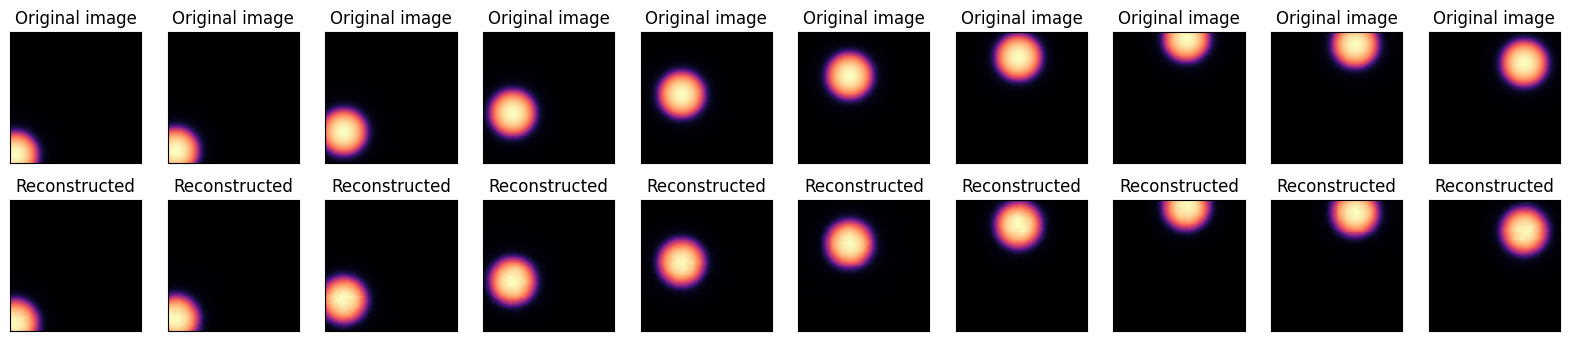

In [12]:
# Saved autoencoders with different bottleneck sizes
autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=256')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=16')

import matplotlib.pyplot as plt

n = sequence_length

original_frames = val_data[0:sequence_length]
encoded_frames = autoencoder.encoder(original_frames).numpy()
decoded_frames = autoencoder.decoder(encoded_frames).numpy()

plt.figure(figsize=(20, 4))

for i in range(sequence_length):
    # Display original frames
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(original_frames[i]), cmap='magma')
    plt.title("Original image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed frames
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(decoded_frames[i]), cmap='magma')
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
# Define the dictionary of autoencoder models to evaluate
autoencoder_models = {
    'autoencoder_256': tf.keras.models.load_model('autoencoder_bottleneck_size=256'),
    'autoencoder_16': tf.keras.models.load_model('autoencoder_bottleneck_size=16')
}

# Loop over the autoencoder models and evaluate the reconstruction loss
for model_name, model in autoencoder_models.items():
    test_loss = model.evaluate(val_data, val_data)
    print(f'{model_name}: Reconstruction loss = {test_loss:.4e}')

125/125 [==============================] - 5s 37ms/step - loss: 1.1403e-05
autoencoder_256: Reconstruction loss = 1.1403e-05
125/125 [==============================] - 4s 34ms/step - loss: 0.0131
autoencoder_16: Reconstruction loss = 1.3054e-02


### Discussion about autoencoder bottleneck size
The performance of an autoencoder typically depends on various factors, including the architecture of the network, the size of the training dataset, and the complexity of the input data. However, in general, the number of features extracted at the bottleneck can have a significant impact on the performance of the autoencoder.

If the number of features extracted at the bottleneck is too small, the autoencoder may not be able to capture all of the important information in the input data. This can lead to poor reconstruction performance and loss of important details in the output.

On the other hand, if the number of features extracted at the bottleneck is too large, the autoencoder may overfit to the training data and fail to generalize well to new, unseen data. Additionally, a larger bottleneck can increase the computational complexity of the model, making it more difficult and expensive to train.

Therefore, finding the optimal number of features to extract at the bottleneck requires balancing the need for a compact representation of the input data with the requirement for accurate reconstruction and good generalization performance. This is often achieved through experimentation and fine-tuning of the autoencoder architecture and hyperparameters.

## Task 2
After pretraining decoder/encoder pair, train the transformer encoder to predict
the downsampled representation of the next video frame. Remember to keep the
pretrained weights of the convolutional encoder/decoder fixed at this stage! Experiment with different number of transformer layers of different sizes. Do these
parameters influence the performance of the network? How far ahead can the transformer predict the sequence of frames? 

In [184]:
Conv2D=keras.layers.Conv2D
MaxPool2D=keras.layers.MaxPooling2D
Dense=keras.layers.Dense
Flatten=keras.layers.Flatten
Reshape=keras.layers.Reshape
Input = keras.layers.Input
Sequential = keras.Sequential
Conv2DTranspose = keras.layers.Conv2DTranspose
Model = tf.keras.Model
GlobalMaxPooling1D = keras.layers.GlobalMaxPooling1D


def transformer_model(bottleneck_size, heads, d_k, d_v, d_ff, seq_len):
    latent_dim = bottleneck_size   # Needs to be same size as bottleneck to be able to pass to decoder in autodecoder
    d_f = bottleneck_size+2
    time_embd = Time2Vector(seq_len)
    attentionL1 = TransformerEncoder(d_k, d_v, heads, d_f, d_ff)
    attentionL2 = TransformerEncoder(d_k, d_v, heads, d_f, d_ff)
    attentionL3 = TransformerEncoder(d_k, d_v, heads, d_f, d_ff)
    
    input_sequence = Input(shape=(seq_len, bottleneck_size))
    x = time_embd(input_sequence)
    x = tf.keras.layers.Concatenate(axis=-1)([input_sequence, x])
    x = attentionL1((x, x, x))
    x = attentionL2((x, x, x))
    x = attentionL3((x, x, x))
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(latent_dim, activation='linear')(x)
    #out = tf.keras.layers.LeakyReLU()(x)
    
    model = Model(inputs=input_sequence, outputs=out)
    model.compile(optimizer='adam', loss=losses.MeanSquaredError())
    return model

### Data preparation for transformer encoder

In [185]:
print(int(train_data.shape[0]/sequence_length))

1600


In [224]:
# Choose which autoencoder to use (Best one is 256)
autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=256')
bottleneck_size = 256
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=16')
#bottleneck_size = 16
sequence_length = 10

#Keep weights the same
autoencoder.trainable = False
autoencoder.encoder.trainable = False
autoencoder.decoder.trainable = False

# Get the encoded representations of the training and validation data
encoded_train = autoencoder.encoder(train_data)
encoded_val = autoencoder.encoder(val_data)

# Reshape the encoded representations to match the input shape of the transformer model
train_predictors = tf.reshape(encoded_train, (int(train_data.shape[0]/sequence_length), sequence_length, bottleneck_size))
train_labels = tf.reshape(train_data, (int(train_data.shape[0]/sequence_length), sequence_length, 64, 64, 1))

val_predictors = tf.reshape(encoded_val, (int(val_data.shape[0]/sequence_length), sequence_length, bottleneck_size))
val_labels = tf.reshape(val_data, (int(val_data.shape[0]/sequence_length), sequence_length, 64, 64, 1))

# Split the training and validation predictors into input and output sequences
train_input_seq = train_predictors[:, :9, :]
train_output_seq = train_predictors[:, 9, :]

val_input_seq = val_predictors[:, :9, :]
val_output_seq = val_predictors[:, 9, :]

### Train models with different number of heads

In [187]:
from tqdm import tqdm
def train_models(heads_list, bottleneck_size):
    # Parameters
    latent_dim = bottleneck_size
    d_k = 256
    d_v = 256
    d_ff = 256
    seq_len = 9
    model_dict = {}
    
    for head in tqdm(heads_list, desc='Processing', position=0):
        # Define new model each iteration
        transformer_model1 = transformer_model(bottleneck_size, head, d_k, d_v, d_ff, seq_len)

        # Define the early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True
        )

        # Train the transformer model
        transformer_model1.fit(
            x=train_input_seq,
            y=train_output_seq,
            batch_size=32,
            epochs=200,
            shuffle=True,
            validation_data=(val_input_seq, val_output_seq),
            callbacks=[early_stopping],
            verbose=1
        )

        # Save the trained model to the dictionary
        model_dict[head] = transformer_model1
    return model_dict

In [188]:
head_list = [2, 12]
model_dict = train_models(head_list, bottleneck_size)

Processing:   0%|                                                                                | 0/2 [00:00<?, ?it/s]

Epoch 1/200
50/50 [==============================] - 17s 205ms/step - loss: 0.1496 - val_loss: 0.0831
Epoch 2/200
50/50 [==============================] - 9s 175ms/step - loss: 0.0865 - val_loss: 0.0746
Epoch 3/200
50/50 [==============================] - 9s 175ms/step - loss: 0.0805 - val_loss: 0.0748
Epoch 4/200
50/50 [==============================] - 9s 174ms/step - loss: 0.0774 - val_loss: 0.0734
Epoch 5/200
50/50 [==============================] - 9s 176ms/step - loss: 0.0760 - val_loss: 0.0724
Epoch 6/200
50/50 [==============================] - 9s 176ms/step - loss: 0.0745 - val_loss: 0.0728
Epoch 7/200
50/50 [==============================] - 9s 177ms/step - loss: 0.0734 - val_loss: 0.0716
Epoch 8/200
50/50 [==============================] - 9s 179ms/step - loss: 0.0724 - val_loss: 0.0708
Epoch 9/200
50/50 [==============================] - 9s 178ms/step - loss: 0.0709 - val_loss: 0.0698
Epoch 10/200
50/50 [==============================] - 9s 177ms/step - loss: 0.0671 - val_l

Processing:  50%|███████████████████████████████████▌                                   | 1/2 [08:03<08:03, 483.73s/it]

Epoch 1/200
50/50 [==============================] - 68s 807ms/step - loss: 0.1419 - val_loss: 0.0809
Epoch 2/200
50/50 [==============================] - 36s 729ms/step - loss: 0.0868 - val_loss: 0.0765
Epoch 3/200
50/50 [==============================] - 36s 718ms/step - loss: 0.0814 - val_loss: 0.0754
Epoch 4/200
50/50 [==============================] - 36s 724ms/step - loss: 0.0793 - val_loss: 0.0749
Epoch 5/200
50/50 [==============================] - 36s 716ms/step - loss: 0.0761 - val_loss: 0.0727
Epoch 6/200
50/50 [==============================] - 36s 730ms/step - loss: 0.0750 - val_loss: 0.0726
Epoch 7/200
50/50 [==============================] - 36s 717ms/step - loss: 0.0743 - val_loss: 0.0728
Epoch 8/200
50/50 [==============================] - 36s 719ms/step - loss: 0.0734 - val_loss: 0.0717
Epoch 9/200
50/50 [==============================] - 36s 724ms/step - loss: 0.0727 - val_loss: 0.0712
Epoch 10/200
50/50 [==============================] - 36s 718ms/step - loss: 0.072

50/50 [==============================] - 40s 804ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 81/200
50/50 [==============================] - 39s 782ms/step - loss: 0.0185 - val_loss: 0.0172
Epoch 82/200
50/50 [==============================] - 39s 789ms/step - loss: 0.0183 - val_loss: 0.0170
Epoch 83/200
50/50 [==============================] - 39s 784ms/step - loss: 0.0177 - val_loss: 0.0168
Epoch 84/200
50/50 [==============================] - 39s 783ms/step - loss: 0.0177 - val_loss: 0.0162
Epoch 85/200
50/50 [==============================] - 39s 784ms/step - loss: 0.0181 - val_loss: 0.0166
Epoch 86/200
50/50 [==============================] - 40s 806ms/step - loss: 0.0189 - val_loss: 0.0168
Epoch 87/200
50/50 [==============================] - 39s 787ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 88/200
50/50 [==============================] - 40s 797ms/step - loss: 0.0176 - val_loss: 0.0166
Epoch 89/200
50/50 [==============================] - 39s 781ms/step - loss: 0.0177 - 

Processing: 100%|████████████████████████████████████████████████████████████████████| 2/2 [1:06:35<00:00, 1997.58s/it]


### Comparing the models

In [189]:
# Loop over the transformer models and evaluate the reconstruction loss
best_model_loss = 1e6
for model_name, model in model_dict.items():
    test_loss = model.evaluate(val_input_seq, val_output_seq)
    print(f'Nr of heads:{model_name}: Prediction loss = {test_loss:.4e}')
    if test_loss < best_model_loss:
        best_model_loss = test_loss
        best_model_key = model_name
        
print(f'Best number of heads: {best_model_key}')

13/13 [==============================] - 1s 56ms/step - loss: 0.0268
Nr of heads:2: Prediction loss = 2.6791e-02
13/13 [==============================] - 3s 215ms/step - loss: 0.0162
Nr of heads:12: Prediction loss = 1.6191e-02
Best number of heads: 12


## Generate a validation data set with video sequence size 20

In [148]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 20  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

In [149]:
data_size = 20
vali_data = retrieve_data(data_size)
np.save('size=20_val_data.npy', vali_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:55<00:00,  2.79s/it]


#### Normalize

In [235]:
data_size = 20
vali_data = np.load('size=20_val_data.npy')
max_val = tf.reduce_max(vali_data, axis=0)
vali_data /= max_val

In [232]:
# Choose which autoencoder to use (Best one is 256)
autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=256')
bottleneck_size = 256

#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=16')
#bottleneck_size = 16

sequence_length = 20

#Keep weights the same
autoencoder.trainable = False
autoencoder.encoder.trainable = False
autoencoder.decoder.trainable = False

# Get the encoded representations of validation data
encoded_val = autoencoder.encoder(vali_data)

# Reshape the encoded representations to match the input shape of the transformer model
val_predictors = tf.reshape(encoded_val, (int(vali_data.shape[0]/sequence_length), sequence_length, bottleneck_size))
val_original = tf.reshape(vali_data, (int(vali_data.shape[0]/sequence_length), sequence_length, 64, 64, 1))

### Prediction on validation data

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
prediction_length = 10

video_idx1 = 4
pred_vid = val_predictors[video_idx1:video_idx1+1, 0:9]
video = val_original[video_idx1, :, :]

for i in range(prediction_length):
    model = model_dict[12]
    prediction = model.predict(pred_vid)
    
    plt.subplot(2, prediction_length, i + 1)
    plt.imshow(tf.squeeze(autoencoder.decoder(prediction)), cmap='magma')
    plt.title(f"Pred_im={i+10}")
    plt.axis('off')
    
    plt.subplot(2, prediction_length, i + 1 + prediction_length)
    plt.imshow(tf.squeeze(video[9+i]), cmap='magma')
    plt.title(f"Orig_im{i+10}")
    plt.axis('off')
    
    if i == 0:
        new_seq = tf.concat([pred_vid[:, 1:, :], tf.expand_dims(prediction, axis=1)], axis=1)
    else:
        new_seq = new_seq[:, 1:, :]
        new_seq = tf.concat([new_seq, tf.expand_dims(prediction, axis=1)], axis=1)
    pred_vid = new_seq

plt.suptitle("Predictions vs. Originals on Validation Set", fontsize=18, fontweight='bold')
plt.subplots_adjust(top=0.85)

#### How does the parameters influence the performance of the network? How far ahead can the transformer predict the sequence of frames?

# Task 3
Benchmark the transformer encoder against a standard recurrent neural networks
by replacing the transformer encoders by one or multiple long short-term memory
(LSTM) layers, and train these layers in the same way as in task 2. How far ahead
can an LSTM-based encoder predict the frames correctly?

In [237]:
LSTM = tf.keras.layers.LSTM
seq_len = 9
def LSTM_model(bottleneck_size):
    latent_dim = bottleneck_size
    input_sequence = Input(shape=(seq_len, bottleneck_size))
    x = LSTM(bottleneck_size*seq_len)(input_sequence)
    x = Dropout(0.1)(x)
    x = Dense(144, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(latent_dim, activation='linear')(x)

    model = tf.keras.Model(inputs=input_sequence, outputs=out)
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    return model

In [238]:
# Define the early stopping callback
LSTM_model = LSTM_model(bottleneck_size)
LSTM_model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the transformer model
LSTM_model.fit(
    x=train_input_seq,
    y=train_output_seq,
    batch_size=32,
    epochs=200,
    shuffle=True,
    validation_data=(val_input_seq, val_output_seq),
    callbacks=[early_stopping],
    verbose=1
)

test_loss = LSTM_model.evaluate(val_input_seq, val_output_seq)
print(f'LTSM Benchmark: Reconstruction loss = {test_loss:.4e}')

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 9, 256)]          0         
                                                                 
 lstm_13 (LSTM)              (None, 2304)              23602176  
                                                                 
 dropout_38 (Dropout)        (None, 2304)              0         
                                                                 
 dense_38 (Dense)            (None, 144)               331920    
                                                                 
 dropout_39 (Dropout)        (None, 144)               0         
                                                                 
 dense_39 (Dense)            (None, 256)               37120     
                                                                 
Total params: 23,971,216
Trainable params: 23,971,216
Non-

In [ ]:
prediction_length = 10
plt.figure(figsize=(20, 4))

for i in range(prediction_length):
    prediction = LSTM_model.predict(pred_vid)
    
    plt.subplot(2, prediction_length, i + 1)
    plt.imshow(tf.squeeze(autoencoder.decoder(prediction)), cmap='magma')
    plt.title(f"Pred_im={i+10}")
    plt.axis('off')
    
    plt.subplot(2, prediction_length, i + 1 + prediction_length)
    plt.imshow(tf.squeeze(video[9+i]), cmap='magma')
    plt.title(f"Orig_im={i+10}")
    plt.axis('off')
    
    if i == 0:
        new_seq = tf.concat([pred_vid[:, 1:, :], tf.expand_dims(prediction, axis=1)], axis=1)
    else:
        new_seq = new_seq[:, 1:, :]
        new_seq = tf.concat([new_seq, tf.expand_dims(prediction, axis=1)], axis=1)
    pred_vid = new_seq

plt.suptitle("Predictions vs. Originals on Validation Set (LSTM)", fontsize=18, fontweight='bold')
plt.subplots_adjust(top=0.85)